<a href="https://colab.research.google.com/github/nyp-sit/it3103/blob/main/week13/intent_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 4a - Training Our Intent Recognition Network

In this practical, we will learn how to apply the HuggingFace Transformers library to our own Intent Recognition task for our chatbot.

Before starting, you can try playing around with Zero-Shot text classification with Huggingface's Transformers library.

https://colab.research.google.com/drive/1jocViLorbwWIkTXKwxCOV9HLTaDDgCaw?usp=sharing


####**NOTE: Be sure to set your runtime to a GPU instance!**

## Section 1 - Install the HuggingFace Transformers Library

Run the following cell below to install the transformers library.

In [1]:
!pip install transformers

     |████████████████████████████████| 2.3MB 30.6MB/s 
     |████████████████████████████████| 3.3MB 45.8MB/s 
     |████████████████████████████████| 901kB 50.9MB/s 


## Section 2 - Import, Define Classes and Helper Functions

Since we have collected a set of sentences and labelled them, let's just try to use those labels as training and test data. Training or fine-tuning the pre-trained model on our own dataset is likely to provide higher accuracy than zero-shot learning.

Run the following cell to import all necessary libraries, define the necessary variables, classes and functions required for our processing.


In [26]:
# Import libraries
#
from transformers import DistilBertTokenizerFast, BertConfig, DistilBertTokenizer, DistilBertModel, DistilBertConfig
import torch

# Initialize our fast DistilBERT tokenizer.
# This will be used later on to tokenize our set of data into individual word 
# indexes.
#
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Declare a dataset class that we will use to pass into our model for training.
#
class SentenceClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    '''
    This function, called during the training, returns the following 
    dictionary (example):
    {
       "input_ids"     : tensor([  101,  2054,  2003, 21725,  2465,  1039,   102,    0, ... ]),
       "attention_mask": tensor([    1,     1,     1,     1,     1,     1,     1,    0, ...]),
       "labels"        : tensor(     1)
    }

    Imagine this function as the one responsible for 'providing' individual
    samples of the training data when asked for.
    '''
    def __getitem__(self, idx):
        # constructs the input Word IDs and the attention mask
        # (or whatever data was generated by the tokenizer)
        #
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # constructs the expected output labels
        # (this is just an index to the expected label, and NOT a one-hot encoding)
        #
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    # This returns the total number of samples in this dataset.
    #
    def __len__(self):
        return len(self.labels)


# This function behaves a little like scikit-learn's train_test_split, 
# except that it doesn't do a random split. Instead, it creates 2 
# sets of data by bunching the data into m (train) + n (test) samples, and
# then splitting each bunch individually into train : test samples.
#
# For example, if the parameters train_samples = 4, and test_samples = 1,
# then the entire dataset is broken up into bunches of 5 samples, where
# the first 4 samples of each bunch goes into the training set, the last 1 
# sample of that bunch goes into the test set:
# 
#   Sample 0 -> Train
#   Sample 1 -> Train
#   Sample 2 -> Train
#   Sample 3 -> Train
#   Sample 4 -> Test

#   Sample 5 -> Train
#   Sample 6 -> Train
#   Sample 7 -> Train
#   Sample 8 -> Train
#   Sample 9 -> Test
#   ...
#
# This is very useful for us to keep a consistent set of train/test split,
# and also helps to ensure consistent split of the classes when the original
# dataset has the output classes sorted/grouped contiguously.
#
def train_test_split_alt(x, y, train_samples=4, test_samples=1):

    # This is the split train/test x/y
    train_x = []
    train_y = []
    test_x = []
    test_y = []

    # Loop through every sample and begin to split by bunches
    #
    for i in range(len(x)):

        # The modulo operator (%) is the one that helps 
        # break up our samples into bunches of (m + n)
        #
        if i % (train_samples + test_samples) < train_samples:
            # The first m samples in our bunch goes into the
            # training set
            #
            train_x.append(x[i])
            train_y.append(y[i])

        else:
            # The next n samples in our bunch goes into the
            # test set
            #
            test_x.append(x[i])
            test_y.append(y[i])
      
    # Finally, return the results in the same form as Scikit-learn's
    # train_test_split function
    #
    return train_x, test_x, train_y, test_y


import pandas as pd

# The following function reads in a CSV and returns a list of input texts, and
# another list of output labels from the column index provided.
#
def load_csv_into_input_text_and_labels(filepath, input_column, output_column):

    # Loads the CSV file 
    df = pd.read_csv(filepath)

    # Create empty lists to hold our input texts and output labels.
    #
    input = df[input_column]
    output = df[output_column]

    return input, output




In [3]:
import pandas as pd

df = pd.read_csv('airchat_intents.csv')

df.head()

,Label,Text
0,atis_abbreviation,what is fare code h
1,atis_abbreviation,what is booking class c
2,atis_abbreviation,what does fare code q mean
3,atis_abbreviation,what is fare code qw
4,atis_abbreviation,what does the fare code f mean


## Section 3 - Defining Our Classification Labels

Run the following cell to declare the sentence classification labels that we will be using.
 

In [7]:
df['Label'].value_counts()

atis_flight                                 3666
atis_airfare                                 423
atis_ground_service                          255
atis_airline                                 157
atis_abbreviation                            147
atis_yes                                      82
atis_aircraft                                 81
atis_no                                       67
atis_flight_time                              54
atis_greeting                                 53
atis_quantity                                 51
atis_flight#atis_airfare                      21
atis_distance                                 20
atis_airport                                  20
atis_city                                     19
atis_ground_fare                              18
atis_capacity                                 16
atis_flight_no                                12
atis_meal                                      6
atis_restriction                               6
atis_airline#atis_fl

In [8]:
# Create a list of unique labels that we will recognize.
#
sentence_labels = [
              "others",
              "atis_abbreviation",
              "atis_aircraft",
              "atis_airfare",
              "atis_airline",
              "atis_flight",
              "atis_flight_time",
              "atis_greeting",
              "atis_ground_service",
              "atis_quantity",
              "atis_yes",
              "atis_no"]

# This creates a reverse mapping dictionary of "label" -> index.
# 
sentence_labels_id_by_label = dict((t, i) for i, t in enumerate(sentence_labels))



In [9]:
sentence_labels_id_by_label

{'atis_abbreviation': 1,
 'atis_aircraft': 2,
 'atis_airfare': 3,
 'atis_airline': 4,
 'atis_flight': 5,
 'atis_flight_time': 6,
 'atis_greeting': 7,
 'atis_ground_service': 8,
 'atis_no': 11,
 'atis_quantity': 9,
 'atis_yes': 10,
 'others': 0}

In [10]:
df['new_label'] = df['Label'].map(lambda label: sentence_labels_id_by_label[label] if label in sentence_labels_id_by_label else 0  )

In [12]:
df.sample(50)

,Label,Text,new_label
3047,atis_flight,i want the flights from denver to pittsburgh,5
1686,atis_flight,show me boston to oakland flights,5
2279,atis_flight,does united airline have any flights from dal...,5
4203,atis_flight,now i need flights leaving from atlanta and a...,5
2718,atis_flight,show me flights from pittsburgh to philadelphia,5
1848,atis_flight,all flights from baltimore to philadelphia le...,5
3968,atis_flight,do you have any flights from boston to dallas...,5
4152,atis_flight,what flights can i find from pittsburgh to sa...,5
3029,atis_flight,i'm looking for a flight from pittsburgh to s...,5
89,atis_abbreviation,what does nw stand for,1


## Section 4 - Load and Split Our Data

We are now prepared to process our data. 

Go ahead and upload the airchat_intent.csv file into Colab.

Then, fill up the codes below to:

1. Load the data from the airchat_intents.csv file. Use the following code to so so:

    ```
    all_texts, all_labels = load_csv_into_input_text_and_labels("airchat_intents.csv", "Text", "Label")
    ```

2. Split the data into training : test (4:1 ratio).

   ```
   train_texts, val_texts, train_labels, val_labels = train_test_split_alt(all_texts, all_labels, 4, 1)
   ```

In [19]:
# TODO:
# Load the CSV into the two variables, all_labels and all_texts
#...#

all_texts = df['Text']
all_labels = df['new_label']
# TODO:
# Split our data into the training and validation dataset in a 4:1 ratio.
#...#
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(all_texts, all_labels, test_size=0.2, stratify=all_labels)

In [22]:
train_labels.value_counts()/len(train_labels)

5     0.707770
3     0.081564
8     0.049228
4     0.030405
1     0.028475
0     0.027751
10    0.015685
2     0.015685
11    0.013031
6     0.010376
7     0.010135
9     0.009894
Name: new_label, dtype: float64

In [23]:
val_labels.value_counts()/len(val_labels)

5     0.707529
3     0.082046
8     0.049228
4     0.029923
1     0.027992
0     0.027992
10    0.016409
2     0.015444
11    0.012548
7     0.010618
6     0.010618
9     0.009653
Name: new_label, dtype: float64

## Section 5 - Preparing Our Data for Training

Modify the following cell to:

1. Convert each classification label into the corresponding index from the above cell. If the classification label doesn't exist in the list above, fall-back to "others"

   ```
   train_labels = [sentence_labels_id_by_label[label] if label in sentence_labels_id_by_label else 0 for label in train_labels]
   val_labels = [sentence_labels_id_by_label[label] if label in sentence_labels_id_by_label else 0 for label in val_labels]
   ```

2. Use the tokenizer to convert all our input text sentences into individual word indexes and attention masks

   ```
   train_encodings = tokenizer(train_texts, truncation=True, padding=True)
   val_encodings = tokenizer(val_texts, truncation=True, padding=True)
   ```

3. Construct the SentenceClassificationDataset in preparation for training. 

   ```
   train_dataset = SentenceClassificationDataset(train_encodings, train_labels)
   val_dataset = SentenceClassificationDataset(val_encodings, val_labels)
   ```

In [24]:
# TODO:
# Convert each classification label into the corresponding index from the 
# above cell. If the classification label doesn't exist in the list above,
# fall-back to "others".
#...#
train_texts = train_texts.to_list()
train_labels = train_labels.to_list()
val_texts = val_texts.to_list()
val_labels = val_labels.to_list()

# TODO:
# Now use the tokenizer to convert all our input text sentences into individual
# word indexes and attention masks. Assign the output from the tokenizer
# to the train_encodings, and val_encodings variables.
#...#


# TODO: 
# Then construct the dataset for the training and validation dataset
#...#


In [28]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [29]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, padding=True, truncation=True)

In [31]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

Run the following cell below to see the train_encodings and the train_label variables for the first few lines of text.

In [32]:
for i in range(5):

    print (train_texts[i])
    print (train_encodings["input_ids"][i])
    print (train_encodings["attention_mask"][i])
    print (train_labels[i])

    print ("---")


 please give grounds transportation at dallas airport
[101, 3531, 2507, 5286, 5193, 2012, 5759, 3199, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8
---
 okay just on november twenty third i want to fly from atlanta to denver and i need to know what flights are available
[101, 3100, 2074, 2006, 2281, 3174, 2353, 1045, 2215, 2000, 4875, 2013, 5865, 2000, 7573, 1998, 1045, 2342, 2000, 2113, 2054, 7599, 2024, 2800, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5
---
 what's the latest flight from san francisco to atlanta
[101, 2054, 1005, 1055, 1996, 674

## Section 6 - Train Your Sentence Classification Model

Run the following cell to download the "distilbert-base-uncased" and perform fine-tuning training on the dataset that we have above.

The following code is based on the sample codes provided at: https://huggingface.co/transformers/training.html 



In [36]:
from transformers import TFAutoModelForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

with training_args.strategy.scope():
  intent_classification_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(sentence_labels))

trainer = TFTrainer(
    model=intent_classification_model,   # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [38]:
trainer.train()

## Section 7 - Saving the Model

When you training has completed, run the following cell to save your model.

Remember to download the model from Google Colab!

In [40]:
# Save the model
#
intent_classification_model.save("intentclassification_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: intentclassification_model/assets


INFO:tensorflow:Assets written to: intentclassification_model/assets


## Section 8 - Evaluating the Model

Run the following code to perform interference for the entire training and validation data set.


In [43]:
preds = trainer.predict(val_dataset)

In [44]:
tf_predictions = tf.nn.softmax(preds.predictions, axis=-1)

In [45]:
y_preds = np.argmax(tf_predictions, axis=-1)


In [46]:
from sklearn.metrics import classification_report

print(classification_report(preds.label_ids, y_preds))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       0.97      0.97      0.97        29
           2       0.94      1.00      0.97        16
           3       0.99      0.95      0.97        85
           4       0.97      1.00      0.98        31
           5       1.00      0.99      0.99       733
           6       0.79      1.00      0.88        11
           7       1.00      1.00      1.00        11
           8       1.00      0.96      0.98        51
           9       0.91      1.00      0.95        10
          10       0.94      1.00      0.97        17
          11       1.00      1.00      1.00        13

    accuracy                           0.99      1036
   macro avg       0.95      0.99      0.97      1036
weighted avg       0.99      0.99      0.99      1036



Then, run the following to evaluation the results.


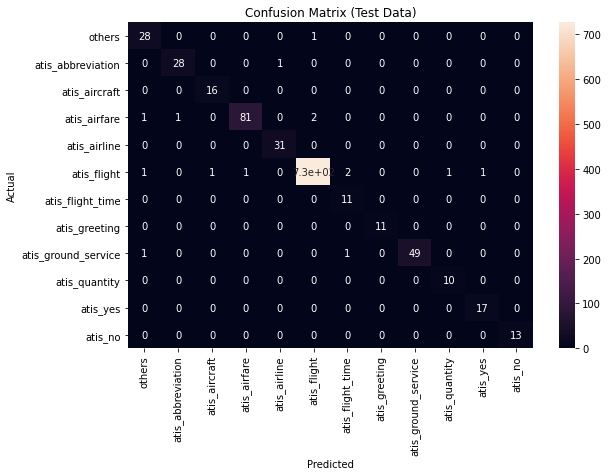

Test Data
--------------------------------------------------------
                     precision    recall  f1-score   support

             others       0.90      0.97      0.93        29
  atis_abbreviation       0.97      0.97      0.97        29
      atis_aircraft       0.94      1.00      0.97        16
       atis_airfare       0.99      0.95      0.97        85
       atis_airline       0.97      1.00      0.98        31
        atis_flight       1.00      0.99      0.99       733
   atis_flight_time       0.79      1.00      0.88        11
      atis_greeting       1.00      1.00      1.00        11
atis_ground_service       1.00      0.96      0.98        51
      atis_quantity       0.91      1.00      0.95        10
           atis_yes       0.94      1.00      0.97        17
            atis_no       1.00      1.00      1.00        13

           accuracy                           0.99      1036
          macro avg       0.95      0.99      0.97      1036
       weighted 

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def display_model_evaluation_results(y_test, pred_y_test, labels):
    
    plt.figure(figsize=(20,6))  

    labels = np.array(labels)

    # Print the second Confusion Matrix for the test data
    #    
    cm = confusion_matrix(y_test, pred_y_test)
    
    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    #
  
    print ("Test Data")
    print ("--------------------------------------------------------")
    print(classification_report(y_test, pred_y_test, target_names=labels))


display_model_evaluation_results(val_labels, y_preds, sentence_labels)

## Section 9 - Putting Our Model to the Test

Run the following cell to create the necessary classes and functions to load our model and perform inference.


In [53]:
# Import the necessary libraries
#
from transformers import TFBertModel, BertTokenizer, BertConfig, DistilBertTokenizerFast, DistilBertModel, DistilBertConfig
import numpy as np
import torch


# Create the DistilBERT tokenizer
#
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to perform inference on a single input text.
# 
def infer_intent(text):
    # Passes the text into the tokenizer
    #
    input = tokenizer(text, truncation=True, padding=True, return_tensors="tf")
    print (input)

    # Sends the result from the tokenizer into our classification model
    #
    output = intent_model(**input, return_dict=True)

    # Extract the output logits of the one and only input text.
    # The logits contains the output from the last layer but without 
    # softmax applied. 
    # 
    output = output.logits[0].numpy()
    print(output)
    
    # Find the classification index with the highest value.
    #  
    label_index = np.argmax(output)

    # Remove all the memory used by CUDA for the inference
    #
    del input
    del output
    torch.cuda.empty_cache()

    # Return the result to the caller
    #
    return label_index

# Create a list of unique labels that we will recognize.
# Obviously this has to match what we trained our model with
# earlier.
#
sentence_labels = [
              "others",
              "atis_abbreviation",
              "atis_aircraft",
              "atis_airfare",
              "atis_airline",
              "atis_flight",
              "atis_flight_time",
              "atis_greeting",
              "atis_ground_service",
              "atis_quantity",
              "atis_yes",
              "atis_no"]

# Load the saved model file
#
intent_model = tf.keras.models.load_model("intentclassification_model")

text = input()

print (sentence_labels[infer_intent(text)])

I want to change my flight
{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 1045, 2215, 2000, 2689, 2026, 3462,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


ValueError: ignored

## Section 10 - Having Fun with a Zero-Shot Text Classifier

This whole section below is independent of the above.

We really just want to see how a zero-shot text classifier works, and if it is any better than what we have trained above. Remember, a zero-shot classifier instantiated here is a totally independent model and has not gone through any training with the dataset we used above.

Run the following cell to initialize the HuggingFace transformer's zero-shot-classification pipeline. 

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", device=0)

Next, let's update the code to prompt for an input sentence, and a few target labels that we want our classifier to classify. These labels should ideally be an English word or sentence. 

Use the following code as an example:

```
sequence = input()
candidate_labels = ["abbreviation", "airfare", "aircraft", "airline", "flight", "flight time", "greeting", "ground service", "quantity", "yes", "no", "others"]
```

Can you potentially see how quickly zero-shot learning can get your Machine Learning / Deep Learning projects up and running?


In [ ]:
# TODO:
# Set up the input sentence and the candidate or target labels that
# you want the zero-shot classifier to identify.
#...#




result = classifier(sequence, candidate_labels)
print ("Recognized label: " + result["labels"][0])

#print (result)

As an optional exercise, you can try to see if you can measure the accuracy of the zero-shot text classifier compared with the one that we have trained with our own dataset.

